In [1]:
import tensorflow as tf
import numpy as np
import typing
import pandas as pd
import seaborn as sns
from tensorflow import keras
from hydra import compose, initialize
from omegaconf import OmegaConf
from musicnet.config.Config import Config
from musicnet.preprocessing.utils import get_datasets_info, load_vocabs
from musicnet.preprocessing.wav_chunks_tfrecord.utils import create_tf_record_ds
from musicnet.models.utils import MODEL_PATH
from musicnet.preprocessing.dataset.base import DsName
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from musicnet.preprocessing.utils import load_source_dataset, get_datasets_info, load_vocabs
import mido

2024-08-30 16:17:51.171725: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 16:17:51.171780: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 16:17:51.171815: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
initialize(version_base=None, config_path="../scripts")
cfg = compose(config_name="defaults", overrides=["stages=[]", "exp=False"])

In [3]:
config = typing.cast(Config, OmegaConf.to_object(cfg))
ds_infos = get_datasets_info(config)

In [4]:
ds_infos

[DsInfo(name='train', config=DsConfig(wav_source=SynthMidiToWavConfig(type=<WavSourceType.SYNTH_MIDI_TO_WAV: 'synth_midi_to_wav'>, tps=100, min_note_ticks=1, max_note_ticks=100, max_silmultaneous_notes=9, sidechannel_sparsity=1, min_note=20, max_note=105, notes_std=20, track_length_per_note=900, velocity_min=64, velocity_max=127), preprocessor=WavChunksTFRecordPreprocessorConfig(type=<PreprocessorType.WAV_CHUNKS_TFRECORDS: 'wav_chunks_tfrecords'>, params=WavChunksTFRecordPreprocessorParams(chunk_size_sec=10, chunk_shift_sec=5, target_sr=44100, note_rounding=0.01, spectogram=SpectogramParams(n_fft=2205, hop_length=441, min_hz=0, n_filters=200, unit=<SpectogramUnit.DECIBELS: 'decibels'>)), file_count=20), batch_size=8, split=None)),
 DsInfo(name='val', config=DsConfig(wav_source=SynthMidiToWavConfig(type=<WavSourceType.SYNTH_MIDI_TO_WAV: 'synth_midi_to_wav'>, tps=100, min_note_ticks=1, max_note_ticks=100, max_silmultaneous_notes=9, sidechannel_sparsity=1, min_note=20, max_note=105, notes

In [5]:
_, notes_vocab = load_vocabs(config)
model = keras.models.load_model(MODEL_PATH)

In [17]:
def tp_fp_fn_by_note_plot(y_true, y_pred):
    counts = pd.DataFrame({
        "note": list(notes_vocab.keys()) * 3,
        "metric": np.repeat(["tp", "fp", "fn"], len(notes_vocab)),
        "value": np.concatenate([
            ((y_true == 1) & (y_pred >= 0)).sum(axis=0),
            ((y_true == 0) & (y_pred >= 0)).sum(axis=0),
            ((y_true == 1) & (y_pred < 0)).sum(axis=0)
        ], axis=0)
    })

    sns.barplot(counts, x="value", y="note", hue="metric", orient="y", ax=plt.gca())

625/625 [==============================] - 27s 43ms/step
(5000, 1000, 85) (5000, 1000, 85)
(5000000, 85) (5000000, 85)
320/320 [==============================] - 14s 44ms/step
(2560, 1000, 85) (2560, 1000, 85)
(2560000, 85) (2560000, 85)


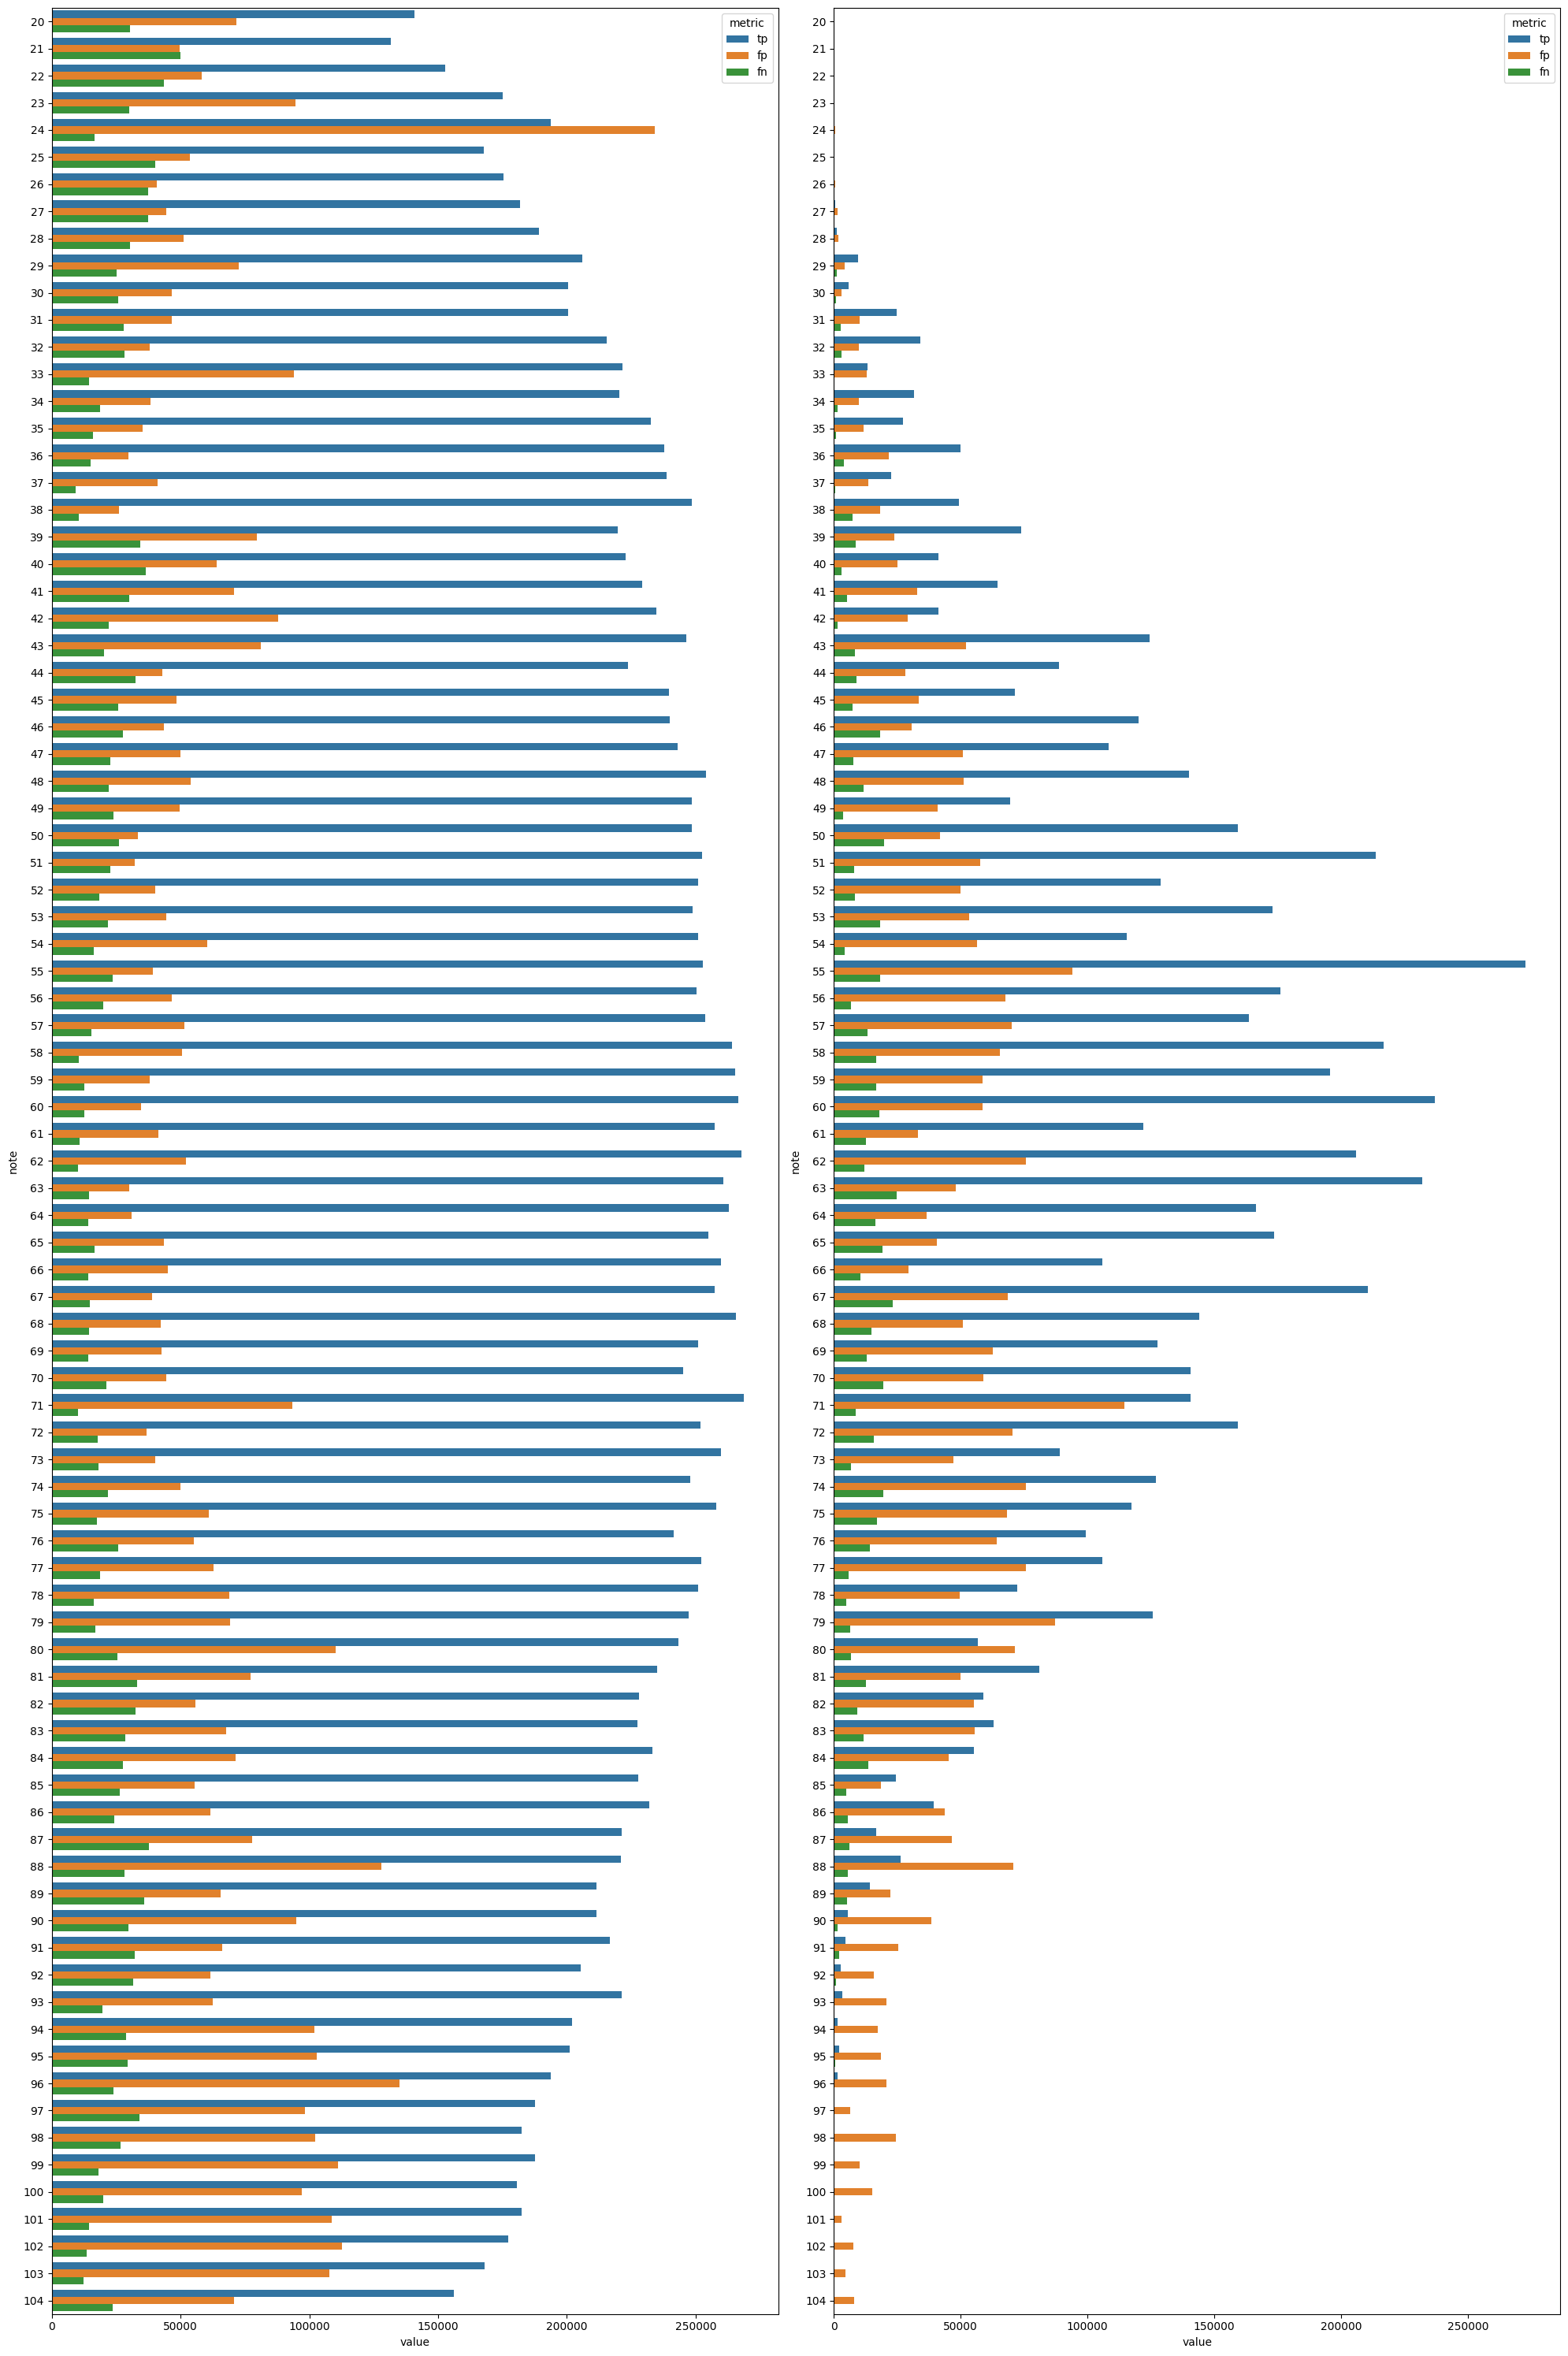

In [18]:
plt.figure(figsize=(20, 30))
for i, ds_info in enumerate(ds_infos[1:]):
    # src_ds = load_source_dataset(ds_info.config, ds_info.src_name)
    ds =  create_tf_record_ds(ds_info.config, ds_info.name, shuffle=False)
    y_true = np.concatenate([y_batch for _, y_batch in ds.as_numpy_iterator()])
    y_pred = model.predict(ds)
    print(y_true.shape, y_pred.shape)
    y_true = y_true.reshape(-1, y_true.shape[-1])
    y_pred = y_pred.reshape(-1, y_pred.shape[-1])
    print(y_true.shape, y_pred.shape)
    plt.subplot(1, 2, i+1)
    tp_fp_fn_by_note_plot(y_true, y_pred)

plt.tight_layout()
plt.show()